<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/midpoint_to_coo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import DataFrame, read_csv, concat
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
from numpy import nan, linspace, min, max, reshape, mean, int64, float64, random, std, arange
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from scipy.stats import norm
from math import sqrt
from gc import collect
from joblib import load
from IPython.display import clear_output
clear_output()

In [ ]:
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep pandas_profiling
!pip list | grep matplotlib
!pip list | grep plotly
!pip list | grep scikit-learn
!pip list | grep scipy
!pip list | grep catboost
!pip list | grep joblib
!pip list | grep ipython

numpy                         1.18.5         
pandas                        1.0.5          
pandas-datareader             0.8.1          
pandas-gbq                    0.11.0         
pandas-profiling              2.8.0          
sklearn-pandas                1.8.0          
matplotlib                    3.2.2          
matplotlib-venn               0.11.5         
plotly                        4.4.1          
scikit-learn                  0.22.2.post1   
scipy                         1.4.1          
catboost                      0.24           
joblib                        0.16.0         
ipython                       5.5.0          
ipython-genutils              0.2.0          
ipython-sql                   0.3.9          


In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_PHA.csv',
              
              dtype={'X1': 'int64',
                     'Y1': 'int64',
                     'X2': 'int64',
                     'Y2': 'int64',
                     'MID_POINT_X': 'float64',
                     'MID_POINT_Y': 'float64',
                     'Area': 'int64',
                     'long': 'float64',
                     'lat': 'float64',},
              
              low_memory=True,
              usecols='MID_POINT_X MID_POINT_Y lat'.split())
             
data = create_table(df.head())
data.show()

In [ ]:
del data
collect() # Garbage collection

19091

In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',},
          inplace=True,) # Rename the column in the same dataframe

ren = create_table(df.head())
ren.show()

In [ ]:
del ren
collect()

19346

In [ ]:
print(df.columns.values)

['MPX' 'MPY' 'lat']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19318

In [ ]:
df1, df2 = df.head(), df.tail()
conc_data_row = concat([df1,
                        df2,],
                        axis=0, # Row-wise operation
                        join='outer',) # Returns both dataframes' columns

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
del df1
collect()

0

In [ ]:
del df2
collect()

0

In [ ]:
assert df['MPX'].notnull().all()
assert df['MPY'].notnull().all()
assert df['lat'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


MPX   NaN
MPY   NaN
lat   NaN
dtype: float64

In [ ]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep=False, # Drop all duplicates
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5,
               how='all', # Only drop columns when all values are NA
               axis='columns',)
df.shape

In [ ]:
df.info(memory_usage='deep') # Actual memory usage calculation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MPX     18 non-null     float64
 1   MPY     18 non-null     float64
 2   lat     18 non-null     float64
dtypes: float64(3)
memory usage: 560.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='Midpoint-Coo Report',
                        explorative=True, # Deeper data insights
                        progress_bar=True,)
profile.to_notebook_iframe() # Display report in output console

In [ ]:
del profile
collect()

59424

In [ ]:
random.seed(10) # Random values but constant
sample_size = 1000
sample = random.choice(a= df['lat'],
                       size = sample_size,)
sample_mean = sample.mean()
z_critical = norm.ppf(q = 0.95)  
print("z-critical value: ",
      z_critical,)   
                             
pop_stdev = df['lat'].std() # Standard deviation of the population
margin_of_error = z_critical * (pop_stdev/sqrt(sample_size)) 
confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:",
      end=" ",)
print(confidence_interval)
print("True mean: {}".format(df['lat'].mean()))

z-critical value:  1.6448536269514722
Confidence interval: (67.14348816610637, 67.14350504589363)
True mean: 67.14350127777777


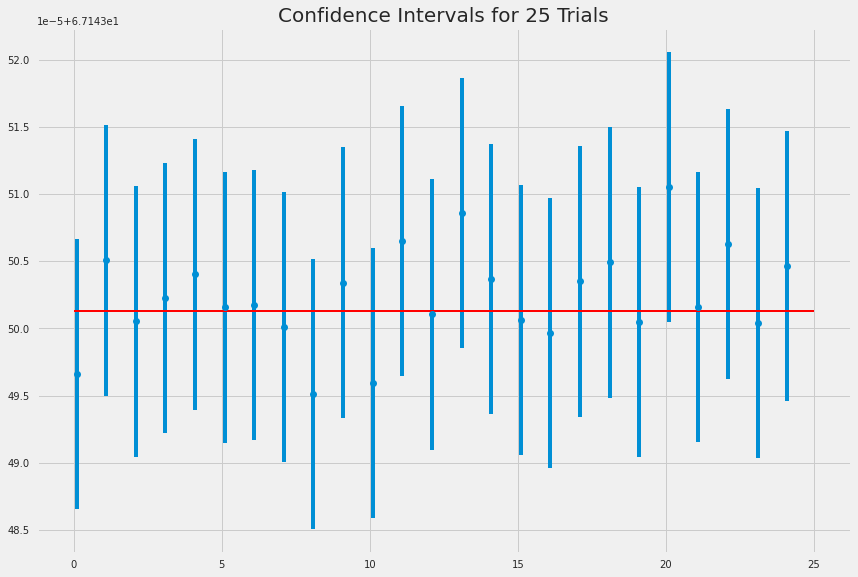

In [ ]:
random.seed(10)
sample_size = 1000
intervals = [] # Empty list
sample_means = []

for sample in range(25):
    sample = random.choice(a= df['lat'], 
                           size = sample_size,)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)
    z_critical = norm.ppf(q = 0.975)
    pop_stdev = df['lat'].std()
    norm.ppf(q = 0.025)
    margin_of_error = z_critical * (pop_stdev/sqrt(sample_size))
    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)  
    
    intervals.append(confidence_interval)
    
plt.figure(figsize=(13, 9))
plt.errorbar(x=arange(0.1, 25, 1), 
             y=sample_means, 
             yerr=[(top-bott)/2 for top, bott in intervals],
             fmt='o',)

plt.hlines(xmin=0,
           xmax=25,
           y=df['lat'].mean(), 
           linewidth=2.0,
           color="red",)

plt.title('Confidence Intervals for 25 Trials',
          fontsize = 20,)
plt.show()

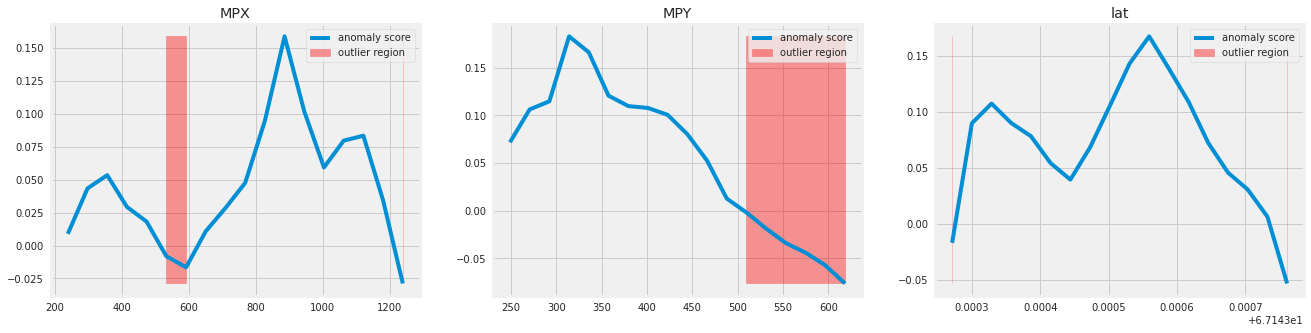

In [ ]:
cols = df
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),)
fig.set_facecolor('w')
fig.set_edgecolor('k')
axs = axs.reshape(-1) # Return a 1D array

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1) # Outlier thresh
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1)) # 2D array

    xx = linspace(df[column].min(), # Starting value of the sequence
                  df[column].max(), # End value of the sequence
                  len(df), # No. of samples to generate
                  endpoint=True,).reshape(-1, 1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score), # Minimum boundary
                        max(anomaly_score), # Maximum boundary
                        where=outlier==-1, # Threshold to fill in a curve
                        color='r', # Fill color
                        alpha=.4, # See overlapped shaded regions
                        label='outlier region',)
    axs[i].legend(frameon=True) # Show box enclosing the legend text
    axs[i].set_title(column)

In [ ]:
# Define predictor (X) and target variables (y)
X = df[['MPX',
        'MPY',]]
        
y = df['lat'].to_numpy().reshape(-1, 1)

In [ ]:
# Reuse the pipeline through the file saved on your device
pipeline = load('/content/pipeline.joblib')
pipeline.fit(X, y.reshape(-1),)

Learning rate set to 0.006657
0:	learn: 0.0001567	total: 46.7ms	remaining: 3m 6s
1:	learn: 0.0001563	total: 47.4ms	remaining: 1m 34s
2:	learn: 0.0001558	total: 47.7ms	remaining: 1m 3s
3:	learn: 0.0001553	total: 48ms	remaining: 47.9s
4:	learn: 0.0001548	total: 48.5ms	remaining: 38.8s
5:	learn: 0.0001543	total: 48.8ms	remaining: 32.5s
6:	learn: 0.0001538	total: 49.2ms	remaining: 28.1s
7:	learn: 0.0001533	total: 49.5ms	remaining: 24.7s
8:	learn: 0.0001529	total: 49.8ms	remaining: 22.1s
9:	learn: 0.0001525	total: 50.1ms	remaining: 20s
10:	learn: 0.0001520	total: 50.4ms	remaining: 18.3s
11:	learn: 0.0001515	total: 50.7ms	remaining: 16.8s
12:	learn: 0.0001511	total: 51ms	remaining: 15.6s
13:	learn: 0.0001506	total: 51.2ms	remaining: 14.6s
14:	learn: 0.0001501	total: 51.5ms	remaining: 13.7s
15:	learn: 0.0001496	total: 51.8ms	remaining: 12.9s
16:	learn: 0.0001491	total: 52.3ms	remaining: 12.2s
17:	learn: 0.0001487	total: 52.5ms	remaining: 11.6s
18:	learn: 0.0001482	total: 52.7ms	remaining: 11s

Pipeline(memory=None,
         steps=[('knnimputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='distance')),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f1330765160>)],
         verbose=False)

In [ ]:
scores = cross_val_score(pipeline,
                         X, y.reshape(-1),
                         cv=18, # 18-fold split
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,) # Use every CPU core
print(scores)

[-2.89491190e-05 -1.29119668e-04 -4.23843497e-05 -1.59099902e-05
 -1.61863611e-05 -1.62029238e-04 -3.83673527e-05 -4.75500380e-05
 -4.59665096e-05 -1.99514469e-06 -6.48224756e-05 -9.33290353e-06
 -7.46733842e-06 -1.69698265e-05 -2.24809726e-05 -2.44195428e-05
 -3.12431877e-05 -3.48877758e-05]


In [ ]:
mean_scores = (-1 * scores.mean())
print('RMSE: {:.4f}'.format(mean_scores))

RMSE: 4.111565524390749e-05
